# Draft Combine Sheets

The NBA Draft Combine is an event that brings amateur athletes together to participate in drills, interview with teams, and showcase their skills prior to the NBA Draft. The athletes go through physical measurements, basketball drills, and medical testing. The [stats.nba.com](https://stats.nba.com) API contains the `draftcombinestats` endpoint that has much of the data recorded at the combine.

This notebook leverages the `Draft` class from the `py_ball` package to explore the `draftcombinestats` endpoint with the goal of producing player sheets that summarize the performance of athletes at the combine.

In [1]:
from io import BytesIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

# Used for writing player summary sheets
from reportlab.pdfgen import canvas
from reportlab.lib.units import inch, cm
from reportlab.lib.pagesizes import letter
from reportlab.lib.utils import ImageReader

from py_ball import draft

HEADERS = {'Connection': 'close',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'Referer': 'stats.nba.com',
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_2)' + \
                         'AppleWebKit/537.36 (KHTML, like Gecko) ' + \
                         'Chrome/66.0.3359.117 Safari/537.36'}

pd.options.mode.chained_assignment = None  # Disabling pandas SetWithCopyWarnings

The `league_id` and `season_year` are required parameters for the `draftcombinestats` endpoint. The NBA is the only league for which data are available, and the cell below pulls data for the most recent draft combine (2018-19 season).

In [2]:
league_id = '00' #NBA
season_year = '2019-20'
draft_data = draft.Draft(headers=HEADERS,
                         endpoint='draftcombinestats',
                         league_id=league_id,
                         season_year=season_year)
draft_df = pd.DataFrame(draft_data.data['DraftCombineStats'])
draft_df.head(10)

,BENCH_PRESS,BODY_FAT_PCT,FIRST_NAME,HAND_LENGTH,HAND_WIDTH,HEIGHT_WO_SHOES,HEIGHT_WO_SHOES_FT_IN,HEIGHT_W_SHOES,HEIGHT_W_SHOES_FT_IN,LANE_AGILITY_TIME,...,SPOT_NBA_CORNER_LEFT,SPOT_NBA_CORNER_RIGHT,SPOT_NBA_TOP_KEY,STANDING_REACH,STANDING_REACH_FT_IN,STANDING_VERTICAL_LEAP,THREE_QUARTER_SPRINT,WEIGHT,WINGSPAN,WINGSPAN_FT_IN
0,NaN,5.9,Nickeil,8.50,8.75,76.25,6' 4.25'',77.50,6' 5.5'',NaN,...,None,None,None,102.0,8' 6'',NaN,NaN,203.8,81.50,6' 9.5''
1,NaN,NaN,RJ,NaN,NaN,NaN,None,NaN,None,NaN,...,None,None,None,NaN,None,NaN,NaN,None,NaN,None
2,7.0,8.5,Charles,9.25,9.50,80.75,6' 8.75'',82.00,6' 10'',12.65,...,2-5,3-5,3-5,109.5,9' 1.5'',29.0,3.53,239,87.50,7' 3.5''
3,4.0,3.6,Darius,9.00,9.75,79.75,6' 7.75'',81.00,6' 9'',11.09,...,3-5,4-5,4-5,107.0,8' 11'',30.5,3.27,208.4,84.00,7' 0''
4,NaN,7.1,Bol,9.25,9.50,84.75,7' 0.75'',86.50,7' 2.5'',NaN,...,None,None,None,115.5,9' 7.5'',NaN,NaN,208,91.00,7' 7''
5,7.0,5.0,Jordan,7.50,9.25,73.50,6' 1.5'',74.75,6' 2.75'',9.97,...,3-5,2-5,5-5,95.0,7' 11'',36.0,3.08,179,75.25,6' 3.25''
6,1.0,6.5,Brian,8.50,9.75,78.25,6' 6.25'',79.50,6' 7.5'',10.98,...,None,None,None,103.0,8' 7'',32.0,3.26,200,82.00,6' 10''
7,4.0,4.9,Ky,8.25,9.00,73.00,6' 1'',74.25,6' 2.25'',11.11,...,4-5,3-5,3-5,98.0,8' 2'',27.5,3.26,181.2,79.00,6' 7''
8,13.0,6.0,Ignas,8.75,9.50,77.75,6' 5.75'',79.25,6' 7.25'',11.06,...,4-5,4-5,2-5,102.0,8' 6'',31.0,3.36,220.8,81.25,6' 9.25''
9,11.0,2.9,O'Shae,9.00,9.50,79.00,6' 7'',80.00,6' 8'',11.30,...,0-5,2-5,4-5,104.0,8' 8'',34.0,3.48,203.2,84.00,7' 0''


The `draft_df` DataFrame has 47 columns, and the view above does not allow one to see all of the feature names. The cell below lists them all.

In [3]:
list(draft_df)

['BENCH_PRESS',
 'BODY_FAT_PCT',
 'FIRST_NAME',
 'HAND_LENGTH',
 'HAND_WIDTH',
 'HEIGHT_WO_SHOES',
 'HEIGHT_WO_SHOES_FT_IN',
 'HEIGHT_W_SHOES',
 'HEIGHT_W_SHOES_FT_IN',
 'LANE_AGILITY_TIME',
 'LAST_NAME',
 'MAX_VERTICAL_LEAP',
 'MODIFIED_LANE_AGILITY_TIME',
 'OFF_DRIB_COLLEGE_BREAK_LEFT',
 'OFF_DRIB_COLLEGE_BREAK_RIGHT',
 'OFF_DRIB_COLLEGE_TOP_KEY',
 'OFF_DRIB_FIFTEEN_BREAK_LEFT',
 'OFF_DRIB_FIFTEEN_BREAK_RIGHT',
 'OFF_DRIB_FIFTEEN_TOP_KEY',
 'ON_MOVE_COLLEGE',
 'ON_MOVE_FIFTEEN',
 'PLAYER_ID',
 'PLAYER_NAME',
 'POSITION',
 'SEASON',
 'SPOT_COLLEGE_BREAK_LEFT',
 'SPOT_COLLEGE_BREAK_RIGHT',
 'SPOT_COLLEGE_CORNER_LEFT',
 'SPOT_COLLEGE_CORNER_RIGHT',
 'SPOT_COLLEGE_TOP_KEY',
 'SPOT_FIFTEEN_BREAK_LEFT',
 'SPOT_FIFTEEN_BREAK_RIGHT',
 'SPOT_FIFTEEN_CORNER_LEFT',
 'SPOT_FIFTEEN_CORNER_RIGHT',
 'SPOT_FIFTEEN_TOP_KEY',
 'SPOT_NBA_BREAK_LEFT',
 'SPOT_NBA_BREAK_RIGHT',
 'SPOT_NBA_CORNER_LEFT',
 'SPOT_NBA_CORNER_RIGHT',
 'SPOT_NBA_TOP_KEY',
 'STANDING_REACH',
 'STANDING_REACH_FT_IN',
 'STANDING_VE

The list above contains about four categories for features:
- Player metadata (`FIRST_NAME`, `LAST_NAME`, `POSITION`, etc.)
- Measurement data (`HAND_LENGTH`, `HAND_WIDTH`, `HEIGHT_WO_SHOES`, etc.)
- Drill data (`BENCH_PRESS`, `LANE_AGILITY_TIME`, `MAX_VERTICAL_LEAP`, etc.)
- Shooting data (`OFF_DRIB_COLLEGE_BREAK_LEFT`, `SPOT_FIFTEEN_BREAK_LEFT`, `SPOT_NBA_TOP_KEY`, etc.)

All of this information seems relevant to include on a player summary sheet. The following sections will organize and manipulate the data so as to produce meaningful results for each data category.

## Player Metadata

The player metadata seems to be the simplest category. The only change necessary would be to create a `FULL_NAME` field.

In [4]:
draft_df['FULL_NAME'] = draft_df['FIRST_NAME'] + ' ' + draft_df['LAST_NAME']

## Measurement Data

Measurement data provide a sense of the size and fitness of an athlete. Due to the nature of NBA positions, players are effective across a wide variety of values of measurement data. This leads to the motivation to present not only the absolute value of measurement data values, but also values normalized by position. Such data transformation illustrates how players compare physically to others that play the same position.

First, the code below explores the measurement data.

In [6]:
measurement_df = draft_df[['PLAYER_ID', 'FULL_NAME', 'POSITION', 'BODY_FAT_PCT', 'HAND_LENGTH', 'HAND_WIDTH',
                           'HEIGHT_WO_SHOES', 'HEIGHT_WO_SHOES_FT_IN', 'HEIGHT_W_SHOES', 'HEIGHT_W_SHOES_FT_IN',
                           'STANDING_REACH', 'STANDING_REACH_FT_IN', 'WEIGHT', 'WINGSPAN', 'WINGSPAN_FT_IN']]
measurement_df.head(20)

,PLAYER_ID,FULL_NAME,POSITION,BODY_FAT_PCT,HAND_LENGTH,HAND_WIDTH,HEIGHT_WO_SHOES,HEIGHT_WO_SHOES_FT_IN,HEIGHT_W_SHOES,HEIGHT_W_SHOES_FT_IN,STANDING_REACH,STANDING_REACH_FT_IN,WEIGHT,WINGSPAN,WINGSPAN_FT_IN
0,1629638,Nickeil Alexander-Walker,SG,5.9,8.50,8.75,76.25,6' 4.25'',77.50,6' 5.5'',102.0,8' 6'',203.8,81.50,6' 9.5''
1,1629628,RJ Barrett,SF,NaN,NaN,NaN,NaN,None,NaN,None,NaN,None,None,NaN,None
2,1629646,Charles Bassey,C,8.5,9.25,9.50,80.75,6' 8.75'',82.00,6' 10'',109.5,9' 1.5'',239,87.50,7' 3.5''
3,1629647,Darius Bazley,PF,3.6,9.00,9.75,79.75,6' 7.75'',81.00,6' 9'',107.0,8' 11'',208.4,84.00,7' 0''
4,1629626,Bol Bol,C,7.1,9.25,9.50,84.75,7' 0.75'',86.50,7' 2.5'',115.5,9' 7.5'',208,91.00,7' 7''
5,1629648,Jordan Bone,SG,5.0,7.50,9.25,73.50,6' 1.5'',74.75,6' 2.75'',95.0,7' 11'',179,75.25,6' 3.25''
6,1628968,Brian Bowen II,SF,6.5,8.50,9.75,78.25,6' 6.25'',79.50,6' 7.5'',103.0,8' 7'',200,82.00,6' 10''
7,1629065,Ky Bowman,PG,4.9,8.25,9.00,73.00,6' 1'',74.25,6' 2.25'',98.0,8' 2'',181.2,79.00,6' 7''
8,1629649,Ignas Brazdeikis,SF,6.0,8.75,9.50,77.75,6' 5.75'',79.25,6' 7.25'',102.0,8' 6'',220.8,81.25,6' 9.25''
9,1629052,O'Shae Brissett,SF-PF,2.9,9.00,9.50,79.00,6' 7'',80.00,6' 8'',104.0,8' 8'',203.2,84.00,7' 0''


Conveniently, many of the measurements have both a value in inches, along with a display-friendly format. Also of note is the format of the `POSITION` field. It appears that players can have multiple positions listed, complicating our plan to normalize by `POSITION` slightly. The following cell drills down into this field further.

In [7]:
measurement_df.groupby('POSITION')['PLAYER_ID'].nunique()

POSITION
          3
C         8
PF       16
PG       13
PG-SG     1
SF       13
SF-PF     4
SG       18
SG-SF     1
Name: PLAYER_ID, dtype: int64

This is speculation, but the primary position of a player appears to be listed first when two are given. Due to the sparsity of some of these positions (including one `SF-PF` player), grouping the players to a single, primary position may lead to more meaningful comparisons.

In [8]:
primary_positions = [pos if '-' not in pos else pos.split('-')[0]
                     for pos in measurement_df['POSITION']]

measurement_df.loc[:, 'PRIMARY_POSITION'] = primary_positions
measurement_df.groupby('PRIMARY_POSITION')['PLAYER_ID'].nunique()

PRIMARY_POSITION
       3
C      8
PF    16
PG    14
SF    17
SG    19
Name: PLAYER_ID, dtype: int64

While 10 players may not provide enough diversity to create meaningful comparisons through normalized values, the `PRIMARY_POSITION` field should be robust enough for an attempt. Also, before normalizing, checking for any `NULL` values is necessary.

In [9]:
measurement_df.isnull().sum()

PLAYER_ID                0
FULL_NAME                0
POSITION                 0
BODY_FAT_PCT             8
HAND_LENGTH              7
HAND_WIDTH               7
HEIGHT_WO_SHOES          7
HEIGHT_WO_SHOES_FT_IN    7
HEIGHT_W_SHOES           7
HEIGHT_W_SHOES_FT_IN     7
STANDING_REACH           7
STANDING_REACH_FT_IN     7
WEIGHT                   8
WINGSPAN                 7
WINGSPAN_FT_IN           7
PRIMARY_POSITION         0
dtype: int64

In [10]:
measurement_df['WEIGHT'] = pd.to_numeric(measurement_df['WEIGHT']) # Weight is returned as a string from the API
normed_measurement_df = measurement_df[['PRIMARY_POSITION', 'BODY_FAT_PCT', 'HAND_LENGTH', 'HAND_WIDTH',
                                        'HEIGHT_WO_SHOES', 'HEIGHT_W_SHOES', 'STANDING_REACH', 'WEIGHT', 'WINGSPAN']]
normed_measurement_df = normed_measurement_df.groupby('PRIMARY_POSITION').transform(lambda x: (x - x.mean()) / x.std())

normed_measurement_df.columns = [orig_name + '_NORM' for orig_name in list(normed_measurement_df)]
normed_measurement_df.head(5)

,BODY_FAT_PCT_NORM,HAND_LENGTH_NORM,HAND_WIDTH_NORM,HEIGHT_WO_SHOES_NORM,HEIGHT_W_SHOES_NORM,STANDING_REACH_NORM,WEIGHT_NORM,WINGSPAN_NORM
0,0.007880,0.000000,-0.609885,0.244374,0.128736,0.515243,0.182911,0.495742
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.510386,-0.591608,-1.028511,-0.863862,-0.912710,-0.597857,0.138880,-0.413846
3,-1.222172,-0.135724,-0.095599,-0.118203,-0.260299,-0.093250,-1.329643,-0.556008
4,0.419010,-0.591608,-1.028511,0.484606,0.547626,0.649844,-1.146279,0.460697


With the normalized features now created, the normalized DataFrame can be merged back into the original DataFrame.

In [11]:
measurement_df = measurement_df.merge(normed_measurement_df, left_index=True, right_index=True)
measurement_df.head(5)

,PLAYER_ID,FULL_NAME,POSITION,BODY_FAT_PCT,HAND_LENGTH,HAND_WIDTH,HEIGHT_WO_SHOES,HEIGHT_WO_SHOES_FT_IN,HEIGHT_W_SHOES,HEIGHT_W_SHOES_FT_IN,...,WINGSPAN_FT_IN,PRIMARY_POSITION,BODY_FAT_PCT_NORM,HAND_LENGTH_NORM,HAND_WIDTH_NORM,HEIGHT_WO_SHOES_NORM,HEIGHT_W_SHOES_NORM,STANDING_REACH_NORM,WEIGHT_NORM,WINGSPAN_NORM
0,1629638,Nickeil Alexander-Walker,SG,5.9,8.50,8.75,76.25,6' 4.25'',77.5,6' 5.5'',...,6' 9.5'',SG,0.007880,0.000000,-0.609885,0.244374,0.128736,0.515243,0.182911,0.495742
1,1629628,RJ Barrett,SF,NaN,NaN,NaN,NaN,None,NaN,None,...,None,SF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1629646,Charles Bassey,C,8.5,9.25,9.50,80.75,6' 8.75'',82.0,6' 10'',...,7' 3.5'',C,1.510386,-0.591608,-1.028511,-0.863862,-0.912710,-0.597857,0.138880,-0.413846
3,1629647,Darius Bazley,PF,3.6,9.00,9.75,79.75,6' 7.75'',81.0,6' 9'',...,7' 0'',PF,-1.222172,-0.135724,-0.095599,-0.118203,-0.260299,-0.093250,-1.329643,-0.556008
4,1629626,Bol Bol,C,7.1,9.25,9.50,84.75,7' 0.75'',86.5,7' 2.5'',...,7' 7'',C,0.419010,-0.591608,-1.028511,0.484606,0.547626,0.649844,-1.146279,0.460697


Now, the `measurement_df` DataFrame contains both absolute and normalized values of the measurement data. Because the goal is to produce a sheet for each player, a function to visualize both of these values for each feature would be valuable. `display_measurement_data` is a function that does just that.

In [12]:
def display_data(player_id, display_data, feature, drills=False):
    """ display_data ingests a player_id and a feature
    in order to produce a relevant visualization.

    @param player_id (int): Unique player identifier
    @param measurement_data (DataFrame): DataFrame containing both
        normalized and absolute values of draft measurement data
    @param feature (str): String corresponding to the feature
        to visualize
    @param drills (boolean): If true, features are normalized across
        all players. If false, features are normalized by PRIMARY_POSITION

    Returns:

        fig (matplotlib.figure.Figure): Figure object visualizing
            the feature of interest
    """

    player_df = display_data[display_data['PLAYER_ID']==player_id]
    position = player_df['PRIMARY_POSITION'].iloc[0]

    # Defining other_feature and units for display purposes
    if feature in ['HEIGHT_W_SHOES', 'HEIGHT_WO_SHOES', 'STANDING_REACH', 'WINGSPAN']:
        other_feature = feature + '_FT_IN'
        units = ''
    elif feature in ['HAND_LENGTH', 'HAND_WIDTH', 'MAX_VERTICAL_LEAP', 'STANDING_VERTICAL_LEAP']:
        other_feature = feature
        units = ' in'
    elif feature == 'WEIGHT':
        other_feature = feature
        units = ' lbs'
    elif feature == 'BODY_FAT_PCT':
        other_feature = feature
        units = '%'
    elif feature in ['LANE_AGILITY_TIME', 'MODIFIED_LANE_AGILITY_TIME', 'THREE_QUARTER_SPRINT']:
        other_feature = feature
        units = ' s'
    elif feature == 'BENCH_PRESS':
        other_feature = feature
        units = ' reps'

    abs_value = str(player_df[other_feature].iloc[0]) + units
    normed_value = player_df[feature + '_NORM'].iloc[0]
    figure_title = other_feature + ': ' + abs_value

    # For drill data, normalize across all players. For measurement data, normalize across PRIMARY_POSITION
    if drills:
        position_df = display_data[pd.notnull(display_data[feature + '_NORM'])]
        position = ''
    else:
        position_df = display_data[(display_data['PRIMARY_POSITION']==position) &
                                   (pd.notnull(display_data[feature + '_NORM']))]

    fig = plt.figure()
    axis = fig.add_axes()

    # Plotting distribution
    plt.hist(position_df[feature + '_NORM'],
             color='grey', bins=6, label='Draft Class ' + position)

    plt.xlim([-5, 5])
    if drills:
        plt.ylim([0, 30])
    else:
        plt.ylim([0, 20])

    # Plotting player and median as vertical lines
    plt.axvline(x=normed_value, color='black', linestyle='--', label=player_df['FULL_NAME'].iloc[0])
    plt.axvline(x=np.median(position_df[feature + '_NORM']),
                color='black', linestyle='-.',
                label='Median: ' + str((round(np.median(position_df[feature]), 1))) + units)
    plt.title(figure_title, fontsize=16)
    plt.xlabel('Normalized Values', fontsize=16)
    plt.ylabel('Count', fontsize=16)

    plt.legend(loc='best', fontsize=10)
    plt.close()

    return fig

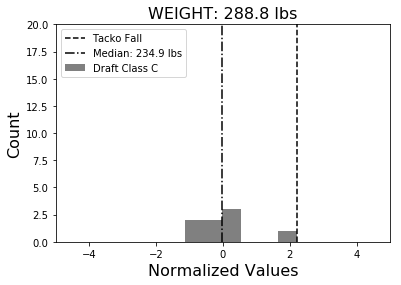

In [13]:
display_data(1629605, measurement_df, 'WEIGHT')

The figure above shows the weight distribution of point guards in the draft combine class, along with the lightest player (Trae Young) weight and the median weight signified by vertical lines. This visualization quickly communicates where on the distribution this player falls relative to players of the same position. Because of the potential for sparsity, the median helps provide additional context.

## Drill Data

Drill data give a snapshot of a player's agility and strength from a variety of tests. Because not all players participate in drills, the drill data will be normalized across all positions. The treatment of these data mirrors that of the measurement data.

In [14]:
drill_df = draft_df[['PLAYER_ID', 'FULL_NAME', 'POSITION', 'BENCH_PRESS', 'LANE_AGILITY_TIME',
                     'MAX_VERTICAL_LEAP', 'MODIFIED_LANE_AGILITY_TIME', 'STANDING_VERTICAL_LEAP',
                     'THREE_QUARTER_SPRINT']]
primary_positions = [pos if '-' not in pos else pos.split('-')[0]
                     for pos in drill_df['POSITION']]

drill_df.loc[:, 'PRIMARY_POSITION'] = primary_positions
drill_df.head(20)

,PLAYER_ID,FULL_NAME,POSITION,BENCH_PRESS,LANE_AGILITY_TIME,MAX_VERTICAL_LEAP,MODIFIED_LANE_AGILITY_TIME,STANDING_VERTICAL_LEAP,THREE_QUARTER_SPRINT,PRIMARY_POSITION
0,1629638,Nickeil Alexander-Walker,SG,NaN,NaN,NaN,NaN,NaN,NaN,SG
1,1629628,RJ Barrett,SF,NaN,NaN,NaN,NaN,NaN,NaN,SF
2,1629646,Charles Bassey,C,7.0,12.65,33.0,3.27,29.0,3.53,C
3,1629647,Darius Bazley,PF,4.0,11.09,37.0,2.95,30.5,3.27,PF
4,1629626,Bol Bol,C,NaN,NaN,NaN,NaN,NaN,NaN,C
5,1629648,Jordan Bone,SG,7.0,9.97,42.5,2.78,36.0,3.08,SG
6,1628968,Brian Bowen II,SF,1.0,10.98,35.5,3.21,32.0,3.26,SF
7,1629065,Ky Bowman,PG,4.0,11.11,33.0,3.11,27.5,3.26,PG
8,1629649,Ignas Brazdeikis,SF,13.0,11.06,36.5,3.17,31.0,3.36,SF
9,1629052,O'Shae Brissett,SF-PF,11.0,11.30,37.5,3.18,34.0,3.48,SF


Examining `drill_df` shoes that some players have missing values, meaning that they likely did not participate in these drills. While unfortunate, dealing with missing data is a common task in data science. The cell below normalizes the drill values, while maintaining for missing values as `NaN`.

In [15]:
normed_drill_df = drill_df[['BENCH_PRESS', 'LANE_AGILITY_TIME',
                            'MAX_VERTICAL_LEAP', 'MODIFIED_LANE_AGILITY_TIME', 'STANDING_VERTICAL_LEAP',
                            'THREE_QUARTER_SPRINT']]

for col_name in list(normed_drill_df):
    normed_drill_df[col_name] = (drill_df[col_name] - np.mean(drill_df[col_name])) / np.std(drill_df[col_name])

normed_drill_df.columns = [orig_name + '_NORM' for orig_name in list(normed_drill_df)]
normed_drill_df.head(5)

,BENCH_PRESS_NORM,LANE_AGILITY_TIME_NORM,MAX_VERTICAL_LEAP_NORM,MODIFIED_LANE_AGILITY_TIME_NORM,STANDING_VERTICAL_LEAP_NORM,THREE_QUARTER_SPRINT_NORM
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.161968,2.461384,-0.786456,0.578946,-0.137505,1.633651
3,-0.775132,-0.185467,0.409989,-1.176811,0.382624,-0.222826
4,NaN,NaN,NaN,NaN,NaN,NaN


Once again, merging the normalized values into the original `drill_df` will allow for the visualization of drill data in the same manner. Because `display_data` is a general function, the same function should work.

In [16]:
drill_df = drill_df.merge(normed_drill_df, left_index=True, right_index=True)
drill_df.head(5)

,PLAYER_ID,FULL_NAME,POSITION,BENCH_PRESS,LANE_AGILITY_TIME,MAX_VERTICAL_LEAP,MODIFIED_LANE_AGILITY_TIME,STANDING_VERTICAL_LEAP,THREE_QUARTER_SPRINT,PRIMARY_POSITION,BENCH_PRESS_NORM,LANE_AGILITY_TIME_NORM,MAX_VERTICAL_LEAP_NORM,MODIFIED_LANE_AGILITY_TIME_NORM,STANDING_VERTICAL_LEAP_NORM,THREE_QUARTER_SPRINT_NORM
0,1629638,Nickeil Alexander-Walker,SG,NaN,NaN,NaN,NaN,NaN,NaN,SG,NaN,NaN,NaN,NaN,NaN,NaN
1,1629628,RJ Barrett,SF,NaN,NaN,NaN,NaN,NaN,NaN,SF,NaN,NaN,NaN,NaN,NaN,NaN
2,1629646,Charles Bassey,C,7.0,12.65,33.0,3.27,29.0,3.53,C,-0.161968,2.461384,-0.786456,0.578946,-0.137505,1.633651
3,1629647,Darius Bazley,PF,4.0,11.09,37.0,2.95,30.5,3.27,PF,-0.775132,-0.185467,0.409989,-1.176811,0.382624,-0.222826
4,1629626,Bol Bol,C,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
drill_df[drill_df['FULL_NAME']=='Kyle Guy']

,PLAYER_ID,FULL_NAME,POSITION,BENCH_PRESS,LANE_AGILITY_TIME,MAX_VERTICAL_LEAP,MODIFIED_LANE_AGILITY_TIME,STANDING_VERTICAL_LEAP,THREE_QUARTER_SPRINT,PRIMARY_POSITION,BENCH_PRESS_NORM,LANE_AGILITY_TIME_NORM,MAX_VERTICAL_LEAP_NORM,MODIFIED_LANE_AGILITY_TIME_NORM,STANDING_VERTICAL_LEAP_NORM,THREE_QUARTER_SPRINT_NORM
24,1629657,Kyle Guy,SG,4.0,10.48,36.5,3.07,30.5,3.27,SG,-0.775132,-1.220453,0.260433,-0.518402,0.382624,-0.222826


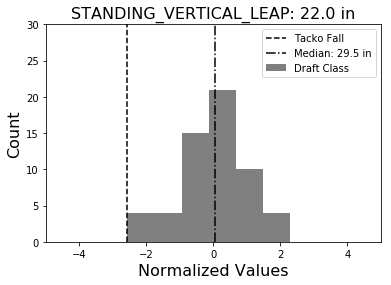

In [19]:
display_data(1629605, drill_df, 'STANDING_VERTICAL_LEAP', True)

The figure above shoes the distribution of `STANDING_VERTICAL_LEAP` for the entire 2018 draft class, along with the leader (Donte DiVincenzo) and the draft class median. DiVencenzo jumped 4.5 inches higher than the median athlete at the combine.

## Shooting Data

The shooting data contain the number of made shots for different shot types from a variety of areas on the court. Visualizing this information on a basketball court would present the shooting results in a concise and efficient manner.

In [20]:
shots_df = draft_df[['PLAYER_ID', 'FULL_NAME', 'POSITION', 'OFF_DRIB_COLLEGE_BREAK_LEFT',
                     'OFF_DRIB_COLLEGE_BREAK_RIGHT', 'OFF_DRIB_COLLEGE_TOP_KEY', 'OFF_DRIB_FIFTEEN_BREAK_LEFT',
                     'OFF_DRIB_FIFTEEN_BREAK_RIGHT', 'OFF_DRIB_FIFTEEN_TOP_KEY', 'ON_MOVE_COLLEGE',
                     'ON_MOVE_FIFTEEN', 'SPOT_COLLEGE_BREAK_LEFT', 'SPOT_COLLEGE_BREAK_RIGHT',
                     'SPOT_COLLEGE_CORNER_LEFT', 'SPOT_COLLEGE_CORNER_RIGHT', 'SPOT_COLLEGE_TOP_KEY',
                     'SPOT_FIFTEEN_BREAK_LEFT', 'SPOT_FIFTEEN_BREAK_RIGHT', 'SPOT_FIFTEEN_CORNER_LEFT',
                     'SPOT_FIFTEEN_CORNER_RIGHT', 'SPOT_FIFTEEN_TOP_KEY', 'SPOT_NBA_BREAK_LEFT',
                     'SPOT_NBA_BREAK_RIGHT', 'SPOT_NBA_CORNER_LEFT', 'SPOT_NBA_CORNER_RIGHT',
                     'SPOT_NBA_TOP_KEY']]

shots_df.head(20)

,PLAYER_ID,FULL_NAME,POSITION,OFF_DRIB_COLLEGE_BREAK_LEFT,OFF_DRIB_COLLEGE_BREAK_RIGHT,OFF_DRIB_COLLEGE_TOP_KEY,OFF_DRIB_FIFTEEN_BREAK_LEFT,OFF_DRIB_FIFTEEN_BREAK_RIGHT,OFF_DRIB_FIFTEEN_TOP_KEY,ON_MOVE_COLLEGE,...,SPOT_FIFTEEN_BREAK_LEFT,SPOT_FIFTEEN_BREAK_RIGHT,SPOT_FIFTEEN_CORNER_LEFT,SPOT_FIFTEEN_CORNER_RIGHT,SPOT_FIFTEEN_TOP_KEY,SPOT_NBA_BREAK_LEFT,SPOT_NBA_BREAK_RIGHT,SPOT_NBA_CORNER_LEFT,SPOT_NBA_CORNER_RIGHT,SPOT_NBA_TOP_KEY
0,1629638,Nickeil Alexander-Walker,SG,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,1629628,RJ Barrett,SF,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,1629646,Charles Bassey,C,None,None,None,1-4,3-4,1-4,None,...,4-5,4-5,4-5,3-5,3-5,2-5,2-5,2-5,3-5,3-5
3,1629647,Darius Bazley,PF,None,None,None,2-4,2-4,0-4,None,...,None,None,None,None,None,2-5,3-5,3-5,4-5,4-5
4,1629626,Bol Bol,C,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
5,1629648,Jordan Bone,SG,None,None,None,3-4,2-4,2-4,None,...,None,None,None,None,None,5-5,2-5,3-5,2-5,5-5
6,1628968,Brian Bowen II,SF,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
7,1629065,Ky Bowman,PG,None,None,None,3-4,1-4,3-4,None,...,None,None,None,None,None,2-5,2-5,4-5,3-5,3-5
8,1629649,Ignas Brazdeikis,SF,None,None,None,1-4,3-4,2-4,None,...,None,None,None,None,None,4-5,4-5,4-5,4-5,2-5
9,1629052,O'Shae Brissett,SF-PF,4-4,3-4,3-4,2-4,3-4,3-4,8-10,...,None,None,None,None,None,4-5,4-5,0-5,2-5,4-5


`shots_df` shows that some players do not participate in all shooting drills. Additionally, the format of the shooting features is `SHOTS MADE - SHOTS ATTEMPTED`, meaning these objects are strings. In order to visualize these shots on a court, a general function that creates a bird's eye view of the court is necessary.

In [21]:
def draw_court():
    """ draw_court draws an NBA halfcourt
    
    Returns:
    
        fig (matplotlib.figure.Figure): Figure object visualizing
            an NBA court
    """

    fig = plt.figure(figsize=(9, 9))
    axis = fig.add_subplot(111, aspect='auto')

    plt.plot([-25, 25], [-4, -4], 'k-') # endline
    plt.plot([-25, 25], [43, 43], 'k-') # halfcourt line
    plt.plot([-25, -25], [-4, 43], 'k-') # sideline
    plt.plot([25, 25], [-4, 43], 'k-') # sideline
    
    plt.plot([-3, 3], [0, 0], 'k-') # backboard
    plt.plot([-6, -6], [-4, 15], 'k-') # lane
    plt.plot([6, 6], [-4, 15], 'k-') # lane
    plt.plot([-8, -8], [-4, 15], 'k-') # lane
    plt.plot([8, 8], [-4, 15], 'k-') # lane
    plt.plot([-8, 8], [15, 15], 'k-') # foul line

    plt.plot([22, 22], [-4, 10], 'k-') # 3pt straight
    plt.plot([-22, -22], [-4, 10], 'k-') # 3pt straight

    three_point = Arc((0, 1), width=23.75*2, height=23.75*2, theta1=22, theta2=158, linewidth=1.5)
    top_key = Arc((0, 15), width=6*2, height=6*2, theta1=0, theta2=180, linewidth=1.5)
    bottom_key = Arc((0, 15), width=6*2, height=6*2, theta1=180, theta2=360, linewidth=1.5, linestyle='--')
    basket = Arc((0, 1), width=0.75*2, height=0.75*2, theta1=0, theta2=360, linewidth=1.5)
    restricted = Arc((0, 0.75), width=4*2, height=4*2, theta1=0, theta2=180, linewidth=1.5)
    half_court = Arc((0, 43), width=6*2, height=6*2, theta1=180, theta2=360, linewidth=1.5)

    axis.add_patch(three_point)
    axis.add_patch(top_key)
    axis.add_patch(bottom_key)
    axis.add_patch(basket)
    axis.add_patch(restricted)
    axis.add_patch(half_court)

    plt.ylim(-5, 45)
    axis.set_aspect(1.0)
    plt.axis('off')

    return fig, axis

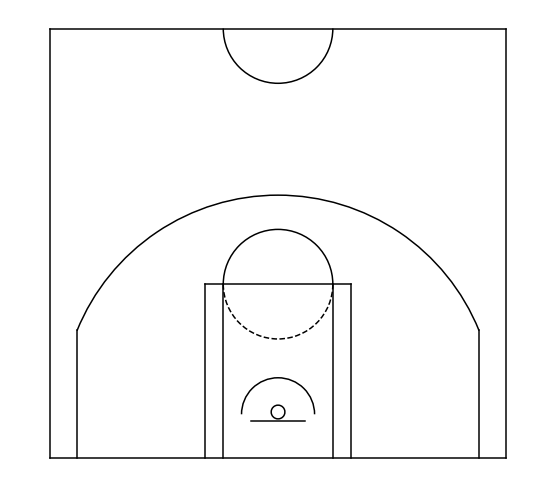

In [22]:
court, court_axis = draw_court()
court

Now that we have a court visualization, each type of shot can be plotted at the different locations described. The shot types are as follows (details below referenced from this [site](https://www.topendsports.com/sport/basketball/testing-skills.htm)):
   - On-the-move: Athletes have 35 seconds to shoot as many shots from 15 feet and college three-point distance while rotating between each corner and elbow
   - Spot Up: Athletes take five spot up shots from each location
   - Off-the-dribble: Athletes take five off-the-dribble shots from each location
    
The following is a function that plots the information on the court.

In [23]:
def plot_shooting_results(shot_type, shot_df, player_id):
    """ plot_shooting_results plots the shooting results
    for a given shot_type.

    @param shot_type (str): One of 'OFF_DRIBBLE', 'ON_MOVE', 'SPOT'
    @param shot_df (DataFrame): DataFrame containing shooting results
    @param player_id (int): Unique player identifier

    Returns:

        fig (matplotlib.figure.Figure): Figure object visualizing
        an NBA court annotated with shooting results for the given player
    """
    fig, axis = draw_court()

    player_df = shot_df[shot_df['PLAYER_ID']==player_id]

    # shot_type dictates the features to plot
    if shot_type == 'ON_MOVE':
        shots = ['ON_MOVE_FIFTEEN', 'ON_MOVE_COLLEGE']
    elif shot_type == 'OFF_DRIBBLE':
        shots = ['OFF_DRIB_COLLEGE_BREAK_LEFT', 'OFF_DRIB_COLLEGE_BREAK_RIGHT',
                 'OFF_DRIB_COLLEGE_TOP_KEY', 'OFF_DRIB_FIFTEEN_BREAK_LEFT',
                 'OFF_DRIB_FIFTEEN_BREAK_RIGHT', 'OFF_DRIB_FIFTEEN_TOP_KEY']
    elif shot_type == 'SPOT':
        shots = ['SPOT_COLLEGE_BREAK_LEFT', 'SPOT_COLLEGE_BREAK_RIGHT',
                 'SPOT_COLLEGE_CORNER_LEFT', 'SPOT_COLLEGE_CORNER_RIGHT', 'SPOT_COLLEGE_TOP_KEY',
                 'SPOT_FIFTEEN_BREAK_LEFT', 'SPOT_FIFTEEN_BREAK_RIGHT', 'SPOT_FIFTEEN_CORNER_LEFT',
                 'SPOT_FIFTEEN_CORNER_RIGHT', 'SPOT_FIFTEEN_TOP_KEY', 'SPOT_NBA_BREAK_LEFT',
                 'SPOT_NBA_BREAK_RIGHT', 'SPOT_NBA_CORNER_LEFT', 'SPOT_NBA_CORNER_RIGHT',
                 'SPOT_NBA_TOP_KEY']

    fifteen = 15
    college = 20.75
    nba = 23.75
    # For all spots from which a shot is taken, a player's performance is plotted
    if shot_type in ['SPOT', 'OFF_DRIBBLE']:
        for shot in shots:
            player_shot = player_df[shot].iloc[0]
            if player_shot is not None:
                if 'COLLEGE' in shot:
                    dist = college
                elif 'FIFTEEN' in shot:
                    dist = fifteen
                elif 'NBA' in shot:
                    dist = nba

                if 'TOP_KEY' in shot:
                    x_loc = 0
                    y_loc = dist + 2
                elif 'CORNER' in shot:
                    if 'LEFT' in shot:
                        x_loc = dist*np.cos(np.deg2rad(5))
                        y_loc = dist*np.sin(np.deg2rad(5)) + 3
                    else:
                        x_loc = -dist*np.cos(np.deg2rad(5))
                        y_loc = dist*np.sin(np.deg2rad(5)) + 3
                elif 'BREAK' in shot:
                    if 'LEFT' in shot:
                        x_loc = dist*np.cos(np.deg2rad(60))
                        y_loc = dist*np.sin(np.deg2rad(60)) + 3
                    else:
                        x_loc = -dist*np.cos(np.deg2rad(60))
                        y_loc = dist*np.sin(np.deg2rad(60)) + 3

                axis.text(x_loc - 1, y_loc, player_shot, fontsize=14)
    else: # For ON_MOVE shots, players rotate between each corner and elbow, so this is designated as a dash-dot arc
        for shot in shots:
            player_shot = player_df[shot].iloc[0]
            if player_shot is not None:
                if 'FIFTEEN' in shot:
                    x_loc = 0
                    y_loc = 15
                    dist_arc = Arc((0, 0), width=15*2, height=15*2, theta1=0, theta2=180, linewidth=1.5, linestyle='-.')
                else:
                    x_loc = 0
                    y_loc = 20.75
                    dist_arc = Arc((0, 0), width=20.75*2, height=20.75*2, theta1=0, theta2=180, linewidth=1.5, linestyle='-.')
                axis.add_patch(dist_arc)
                axis.text(x_loc - 2, y_loc + 0.5, player_shot, fontsize=14)

    plt.title(player_df['FULL_NAME'].iloc[0] + ' ' + shot_type.replace('_', ' ').title() + ' Shooting', fontsize=16)
    plt.close()
    return fig

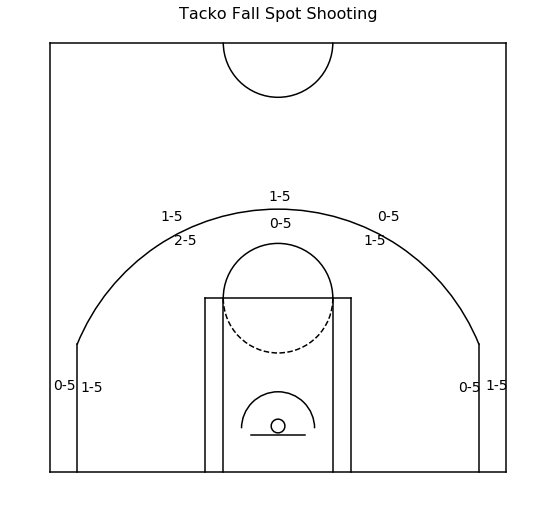

In [25]:
court = plot_shooting_results('SPOT', shots_df, 1629605)
court

## Player Summary Sheets
With all of the types of data explored above, a player summary sheet can be formed from displaying the useful data and visualizations developed. The function below, `write_summary_sheet`, leverages the `reportlab` package to write the summary sheet to a PDF file. More information on `reportlab` can be found [here](https://www.reportlab.com/docs/reportlab-userguide.pdf). `draw_figure` is a helper function that draws a `matplotlib` figure object on a `reportlab.canvas.Canvas` object.

`reportlab` is a fairly low level wrapper that allows users to customize PDFs. The code below leverages the coordinate system of a `reportlab` PDF object, which has its origin in the bottom left corner of the page. Here is the size of the `letter` PDF page. The functions below take advantage of `inch`, which makes sizing and spacing easier.

In [26]:
letter

(612.0, 792.0)

In [27]:
def draw_figure(pdf, fig, location, image_size):
    """ draw_figure draws a figure on a PDF

    @param pdf (canvas.Canvas): PDF object of summary sheet
    @param fig (matplotlib.fig.Figure): Figure object to be
        drawn on the PDF
    @param location (list): [x, y] location at which to draw
        the fig object on the PDF
    @param image_size (float): width of the image to be drawn

    Returns:

        pdf (canvas.Canvas): PDF object on which the fig
            object is drawn
    """

    img_in_memory = BytesIO()
    fig.savefig(img_in_memory, format='png', bbox_inches='tight', dpi=500)
    image = ImageReader(img_in_memory)

    # Ensure the aspect ratio is maintained
    width, height = image.getSize()
    aspect = height/float(width)

    pdf.drawImage(image, location[0], location[1], image_size, image_size*aspect)

    return pdf

def write_summary_sheet(player_id, draft_df, measurement_df, drill_df, shots_df):
    """ write_summary_sheet creates a player summary sheet for the player
    provided

    @param player_id (int): Unique player identifier
    @param draft_df (DataFrame): DataFrame containing draft data from the API
    @param measurement_df (DataFrame): DataFrame containing measurement-specific
        data
    @param drill_df (DataFrame): DataFrame containing drill-specific
        data
    @param shots_df (DataFrame): DataFrame containing shot-specific
        data

    Returns:

        PDF of the format '[first_name]_[last_name]_summary_sheet.pdf'
            written in the current working directory
    """
    
    player_df = draft_df[draft_df['PLAYER_ID']==player_id].iloc[0]
    pdf_object = canvas.Canvas(player_df['FULL_NAME'].lower().replace(' ', '_') + '_summary_sheet.pdf')

    # Write player metadata
    pdf_object.setFont('Helvetica', 12)
    pdf_object.drawCentredString(letter[0]/2, letter[1] + 25, 'NBA Draft Combine Player Summary')
    pdf_object.setFont('Helvetica-Bold', 16)
    pdf_object.drawCentredString(letter[0]/2, letter[1], player_df['FULL_NAME'])
    ###################################

    # Write player measurement data
    pdf_object.setFont('Helvetica', 12)
    pdf_object.drawCentredString(letter[0]/2, letter[1] - 30, 'Measurements')
    weight_image = display_data(player_id, measurement_df, 'WEIGHT')
    pdf = draw_figure(pdf_object, weight_image, [letter[0]/64, letter[1] - inch*2], inch*2)

    height_image = display_data(player_id, measurement_df, 'HEIGHT_WO_SHOES')
    pdf = draw_figure(pdf_object, height_image, [letter[0]/64 + inch*2, letter[1] - inch*2], inch*2)

    reach_image = display_data(player_id, measurement_df, 'STANDING_REACH')
    pdf = draw_figure(pdf_object, reach_image, [letter[0]/64 + inch*4, letter[1] - inch*2], inch*2)

    wing_image = display_data(player_id, measurement_df, 'WINGSPAN')
    pdf = draw_figure(pdf_object, wing_image, [letter[0]/64 + inch*6, letter[1] - inch*2], inch*2)
    ###################################

    # Write player drill data
    pdf_object.setFont('Helvetica', 12)
    pdf_object.drawCentredString(letter[0]/2, letter[1] - inch*2.5, 'Drills')
    bench_image = display_data(player_id, drill_df, 'BENCH_PRESS', drills=True)
    pdf = draw_figure(pdf_object, bench_image, [letter[0]/32, letter[1] - inch*4.5], inch*2.5)

    stand_image = display_data(player_id, drill_df, 'STANDING_VERTICAL_LEAP', drills=True)
    pdf = draw_figure(pdf_object, stand_image, [letter[0]/32 + inch*2.5, letter[1] - inch*4.5], inch*2.5)

    leap_image = display_data(player_id, drill_df, 'MAX_VERTICAL_LEAP', drills=True)
    pdf = draw_figure(pdf_object, leap_image, [letter[0]/32 + inch*5, letter[1] - inch*4.5], inch*2.5)

    lane_image = display_data(player_id, drill_df, 'LANE_AGILITY_TIME', drills=True)
    pdf = draw_figure(pdf_object, lane_image, [letter[0]/32, letter[1] - inch*6.5], inch*2.5)

    mod_lane_image = display_data(player_id, drill_df, 'MODIFIED_LANE_AGILITY_TIME', drills=True)
    pdf = draw_figure(pdf_object, mod_lane_image, [letter[0]/32 + inch*2.5, letter[1] - inch*6.5], inch*2.5)

    sprint_image = display_data(player_id, drill_df, 'THREE_QUARTER_SPRINT', drills=True)
    pdf = draw_figure(pdf_object, sprint_image, [letter[0]/32 + inch*5, letter[1] - inch*6.5], inch*2.5)
    ###################################

    # Write player shot data
    pdf_object.setFont('Helvetica', 12)
    pdf_object.drawCentredString(letter[0]/2, letter[1] - inch*7, 'Shot Charts')
    spot_image = plot_shooting_results('SPOT', shots_df, player_id)

    dribble_image = plot_shooting_results('OFF_DRIBBLE', shots_df, player_id)

    move_image = plot_shooting_results('ON_MOVE', shots_df, player_id)

    # Drawing figures so that overlapping does not distory the images
    pdf = draw_figure(pdf_object, move_image, [letter[0]/64 + inch*6 - 55, letter[1] - inch*10], inch*3)
    pdf = draw_figure(pdf_object, dribble_image, [letter[0]/64 + inch*3 - 40, letter[1] - inch*10], inch*3)
    pdf = draw_figure(pdf_object, spot_image, [letter[0]/64 - 25, letter[1] - inch*10], inch*3)
    ###################################

    pdf_object.showPage()
    pdf_object.save()

In [38]:
write_summary_sheet(1629657, draft_df, measurement_df, drill_df, shots_df)

## Exploration

- The code above makes several design choices for each visualization. Can you create other visualizations to display the information meaningfully?
- Redesign the summary sheet with a different format or other visualizations.
- Change the `season_year` to exlpore data from other draft combines.
- Rather than having a sheet for each player, create a summary sheet for the draft combine as a whole.